In [1]:
# Enable inline plotting for notebooks
%matplotlib inline

In [255]:
import re
from difflib import SequenceMatcher
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# -----------------------------
# Parameters
# -----------------------------
DATA_PATH = "data/interdisciplinary/WorldWideDishes_2024_June.xlsx"
MIN_RECIPES_PER_INGREDIENT = 3
MIN_INGREDIENTS_PER_RECIPE = 3

# -----------------------------
# Load + validate
# -----------------------------
df = pd.read_excel(DATA_PATH)

required_cols = {"id", "ingredients"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df.set_index("id", drop=True)

# -----------------------------
# Junk filters
# -----------------------------
BAD_TOKENS = {
    "etc",
    "and or others",
    "or spinach leaves",
    "knorr etc",
    "the bark of lep",
    # "fruits", "vegetables", "meat",
    # "oil", "water", "seasoning", "spices", "salt",
}

BAD_PHRASE_RE = re.compile(
    r"\b(" r"etc|and or|or .*|of choice|as needed|optional|" r"your |made from|mixed with" r")\b"
)


# -----------------------------
# Cleaning helpers
# -----------------------------
def clean_ingredient(token):
    if not isinstance(token, str):
        return ""
    token = token.lower()
    token = re.sub(r"\([^)]*\)", "", token)
    token = re.sub(r"[\"'“”‘’]", "", token)
    token = re.sub(r"[^a-z0-9\s]", " ", token)
    return re.sub(r"\s+", " ", token).strip()


def parse_and_clean_ingredients(s):
    if not isinstance(s, str):
        return []
    toks = []
    for raw in s.split(","):
        tok = clean_ingredient(raw)
        if not tok:
            continue
        if tok in BAD_TOKENS:
            continue
        if BAD_PHRASE_RE.search(tok):
            continue
        toks.append(tok)
    return toks


def is_near_spelling_variant(a, b):
    return SequenceMatcher(None, a, b).ratio() >= 0.90


# Parse ingredients
df["ingredients_clean"] = df["ingredients"].apply(parse_and_clean_ingredients)
ingredient_lists = df["ingredients_clean"]

# Build raw vocab
all_ingredients = sorted({ing for lst in ingredient_lists for ing in lst})

In [256]:
# ------------------------------------------------------------
# Explicit, human-approved spelling corrections (high confidence)
# ------------------------------------------------------------
EXPLICIT_CANONICAL = {
    # clear typos / orthographic errors
    "balck pepper": "black pepper",
    "bananaleaf": "banana leaf",
    "carrots": "carrot",
    "casava": "cassava",
    "chickpeas": "chickpea",
    "chilli": "chili",
    "chilli pepper": "chili pepper",
    "cinamon": "cinnamon",
    "cloves": "clove",
    "curry poweder": "curry powder",
    "dryred chilli": "dry red chili",
    "garli": "garlic",
    "giner": "ginger",
    "green chilli": "green chili",
    "ground cardamon": "ground cardamom",
    "onions": "onion",
    "red chiili": "red chili",
    "red chilli powder": "red chili powder",
    "shallots": "shallot",
    "tumeric": "turmeric",
    "tumeric powder": "turmeric powder",
    "yoghurt": "yogurt",
}

# Canonicalize near-identical spellings
canonical_map = {}
canonical_ingredients = []

for ing in all_ingredients:
    # Highest priority: explicit, human-approved corrections
    if ing in EXPLICIT_CANONICAL:
        canon = EXPLICIT_CANONICAL[ing]
        canonical_map[ing] = canon
        if canon not in canonical_ingredients:
            canonical_ingredients.append(canon)
        continue

    # Conservative automatic grouping
    for canon in canonical_ingredients:
        if is_near_spelling_variant(ing, canon):
            canonical_map[ing] = canon
            break
    else:
        canonical_map[ing] = ing
        canonical_ingredients.append(ing)

# Report merges (optional transparency)
grouped = defaultdict(list)
for ing, canon in canonical_map.items():
    if ing != canon:
        grouped[canon].append(ing)

if grouped:
    print("Grouped spelling variants:")
    for canon, vars_ in sorted(grouped.items()):
        print(f"  {canon} <- {', '.join(sorted(vars_))}")

ingredients = canonical_ingredients
print(f"Final ingredient vocabulary: {len(ingredients)}")

Grouped spelling variants:
  banana leaf <- bananaleaf
  beef stripes <- beef tripe
  black bean <- black beans
  black eyed pea <- black eyed peas
  black pepper <- balck pepper
  carrot <- carrots
  cassava <- casava
  chickpea <- chickpeas
  chili <- chilli
  chili pepper <- chilli pepper
  cinnamon <- cinamon
  clove <- cloves
  coariander leaves <- corainder leaves, coriander leaves
  coriander powder <- corianer powder
  curry powder <- curry poweder
  dried shrimp <- fried shrimp
  dry red chili <- dryred chilli
  eggplant <- eggplants
  garlic <- garli
  ginger <- giner
  ginger paste <- gingerpaste
  green chili <- green chilli
  green pepper <- green peppers
  ground cardamom <- ground cardamon
  heavey cocnut milk <- heavy coconut milk
  kechup <- ketchup
  kidney <- kidneys
  onion <- onions
  ox tail <- oxtail
  papaya <- pappaya
  peanut <- peanuts
  pepper <- peppers
  plantain <- plantains
  red chili <- red chiili, red chilli
  red chili powder <- red chilli powder
  r

In [257]:
# ============================================================
# Build ingredient × recipe matrix (binary, sparse-backed)
# ============================================================
#
# Rows    = recipe IDs
# Columns = canonicalized ingredient tokens
# Value   = 1 if ingredient is present in recipe, else 0
#
# Notes
# -----
# - Deterministic construction
# - No semantic collapsing beyond explicit canonical rules
# - Suitable as direct input to HiMaLAYAS Matrix
# ============================================================

# Map ingredients to columns
ingredient_to_col = {ing: i for i, ing in enumerate(ingredients)}

row_idx = []
col_idx = []
data = []

for i, ing_list in enumerate(ingredient_lists):
    seen = set()
    for ing in ing_list:
        canon = canonical_map.get(ing, ing)
        if canon in seen:
            continue
        seen.add(canon)
        row_idx.append(i)
        col_idx.append(ingredient_to_col[canon])
        data.append(1)

# Build sparse matrix (CSR for efficiency, but logic is format-agnostic)
X = csr_matrix(
    (data, (row_idx, col_idx)),
    shape=(len(df), len(ingredients)),
    dtype=np.uint8,
)

# Wrap as sparse-backed DataFrame
ingredient_matrix = pd.DataFrame.sparse.from_spmatrix(
    X,
    index=df.index,
    columns=ingredients,
)

# ------------------------------------------------------------
# Frequency-based filtering
# ------------------------------------------------------------
ingredient_support = ingredient_matrix.sum(axis=0)
cols_keep = ingredient_support[ingredient_support >= MIN_RECIPES_PER_INGREDIENT].index
ingredient_matrix = ingredient_matrix.loc[:, cols_keep]

row_keep = ingredient_matrix.sum(axis=1) >= MIN_INGREDIENTS_PER_RECIPE
ingredient_matrix = ingredient_matrix.loc[row_keep]

print(f"Ingredient matrix shape: {ingredient_matrix.shape} | " f"kept {len(cols_keep)} ingredients")

Ingredient matrix shape: (537, 238) | kept 238 ingredients


In [258]:
# ============================================================
# Build country → recipe ID mapping
# ============================================================

from collections import defaultdict

if "countries" not in df.columns:
    raise ValueError("Column 'countries' not found in df")


def parse_countries(s):
    if not isinstance(s, str):
        return []
    return [tok.strip().lower() for tok in s.split(",") if tok.strip()]


country_to_recipes = defaultdict(set)

for recipe_id, country_str in df["countries"].items():
    for country in parse_countries(country_str):
        country_to_recipes[country.title()].add(recipe_id)

country_to_recipes = {country: sorted(ids) for country, ids in country_to_recipes.items()}

print(f"Number of countries: {len(country_to_recipes)}")

Number of countries: 106


In [262]:
from himalayas import Matrix, Annotations, Analysis
from himalayas.text import summarize_clusters

LINKAGE_THRESHOLD = 8.5

matrix = Matrix(ingredient_matrix)

annotations = Annotations(
    country_to_recipes,
    matrix,
)

analysis = (
    Analysis(matrix, annotations)
    .cluster(
        linkage_method="ward",
        linkage_metric="euclidean",
        linkage_threshold=LINKAGE_THRESHOLD,
        min_cluster_size=18,
    )
    .enrich(min_overlap=2)
    .finalize(
        col_cluster=True,
        add_qvalues=True,
    )
)

results = analysis.results
results_sig = results.filter("qval <= 0.05")

# ------------------------------------------------------------
# Summarize clusters into plot-ready textual labels
# ------------------------------------------------------------
cluster_labels = summarize_clusters(
    results_sig.df,
    label_mode="top_term",
)
cluster_labels["label"] = cluster_labels["label"].str.title()

# Quick sanity preview
print(f"All enriched rows: {len(results.df):,}")
print(f"Significant rows (q<=0.05): {len(results_sig.df):,}")
print(results_sig.df.head(10))

print("\nCluster-level labels:")
print(cluster_labels)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 13/106 annotations with no overlap to matrix labels
  warn(


All enriched rows: 91
Significant rows (q<=0.05): 18
   cluster                              term   k   K    n    N          pval  \
0        3                             India  22  55   22  537  1.972080e-24   
1        4                           Nigeria  25  58   40  537  4.090781e-17   
2        6                             Japan  17  18   87  537  1.390607e-13   
3        7  Democratic Republic Of The Congo  14  17  121  537  1.699435e-07   
4        7                           Algeria  36  80  121  537  9.162448e-07   
5        8                       Philippines  13  26   78  537  1.079136e-05   
6        1                           Algeria  15  80   39  537  1.451353e-04   
7        5                             Kenya  17  65   61  537  2.826877e-04   
8        1                           Morocco   4   6   39  537  3.232633e-04   
9        1                       Netherlands   3   3   39  537  3.560878e-04   

           qval  
0  1.794593e-22  
1  1.861305e-15  
2  4.218175e

In [263]:
# ============================================================
# Colormap for -log10(p-value) in range [0, max]
# ============================================================

import numpy as np
from matplotlib.colors import LinearSegmentedColormap


def make_diverging_cmap(
    neg="#000000",
    pos="#FF0033",
    mid="#FF0033",
    name="BlackRed",
    N=256,
):
    """
    Create a diverging colormap with a neutral midpoint.

    Colors are specified in visual space only.
    Data centering must be handled by a normalization (e.g. TwoSlopeNorm).

    Returns
    -------
    matplotlib.colors.LinearSegmentedColormap
    """
    return LinearSegmentedColormap.from_list(
        name,
        [(0.0, neg), (0.5, mid), (1.0, pos)],
        N=N,
    )


# Use the standardized diverging colormap helper (blue → white → yellow)
matrix_cmap = make_diverging_cmap(
    neg="#000000",
    pos="#FF0033",
    mid="#FF0033",
    name="BlackRed",
)

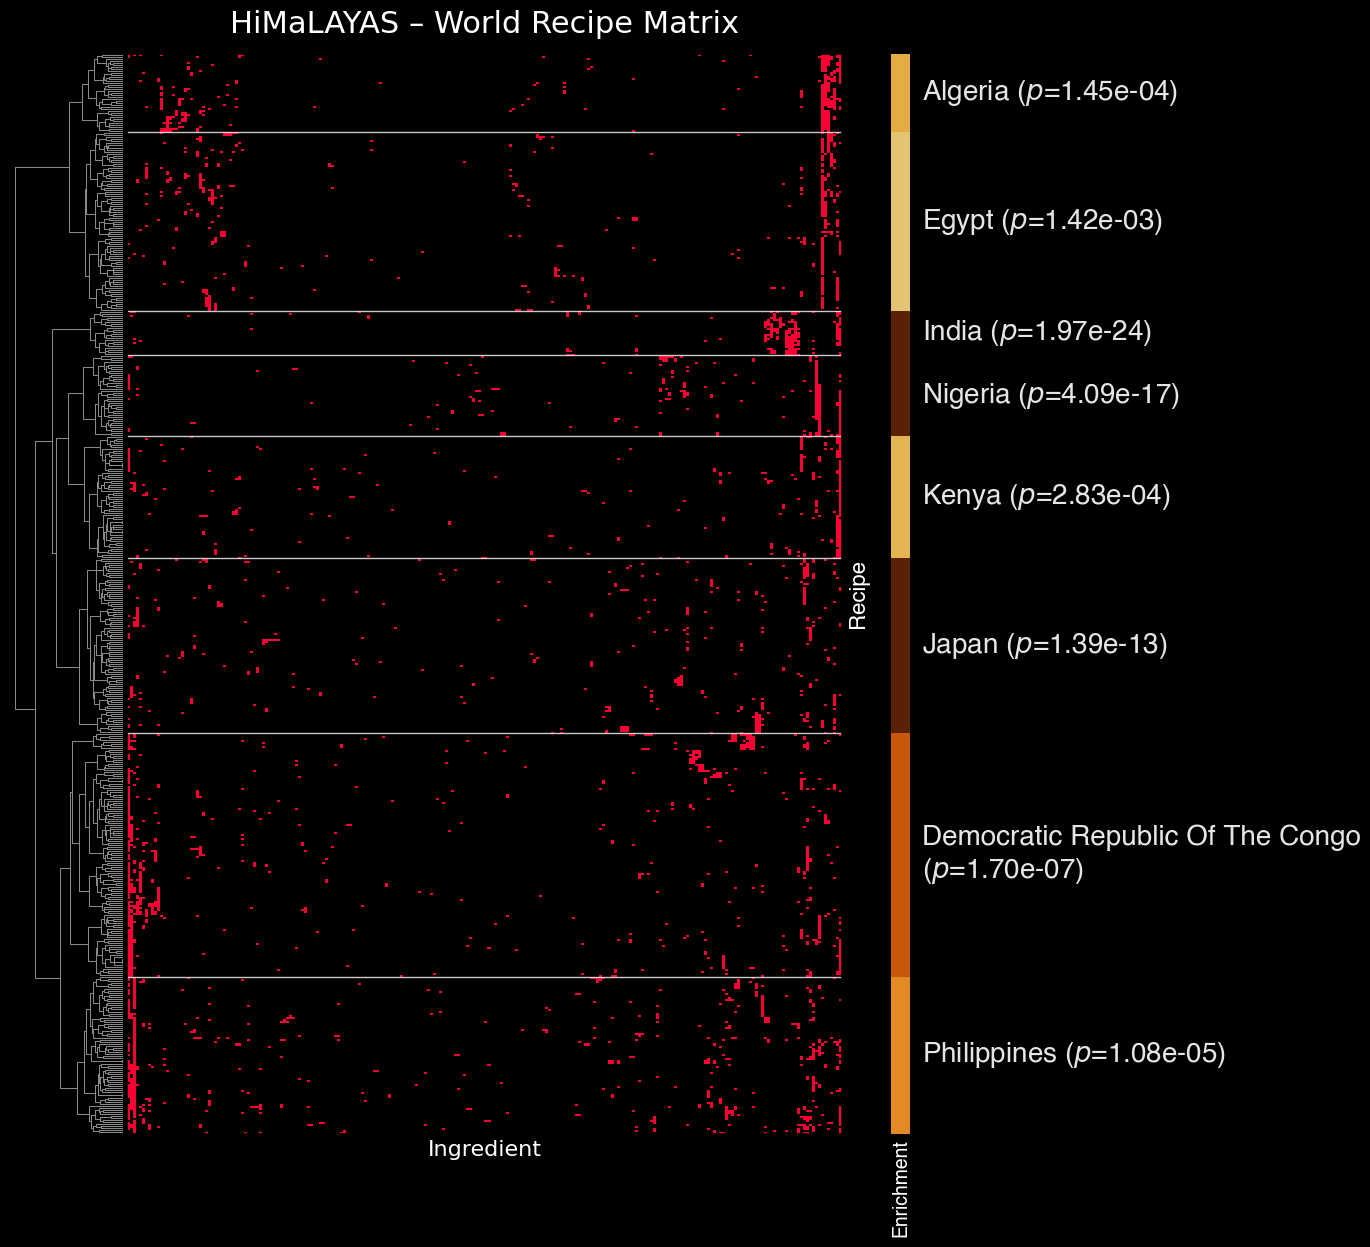

In [265]:
import numpy as np

from matplotlib.colors import Normalize

from himalayas.plot import Plotter

LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"
FONT = "Helvetica"

# Create the plotter with your enrichment results
plotter = Plotter(results)

(
    plotter.plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        figsize=(13, 12),
        subplots_adjust={
            "left": 0.15,
            "right": 0.70,
            "bottom": 0.05,
            "top": 0.95,
        },
    )
    .plot_matrix_axis_labels(
        xlabel="Ingredient",
        ylabel="Recipe",
        fontsize=16,
        color=LABEL_COLOR,
        xlabel_pad=4.5,
        ylabel_pad=0.005,
    )
    .plot_cluster_labels(  # Cluster-level functional annotations
        cluster_labels,
        max_words=24,
        wrap_text=True,  # enable wrapping
        wrap_width=36,  # characters per line (tune if needed)
        overflow="wrap",  # never ellipsize
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "p"),
        omit_words={},
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color=LABEL_COLOR,
        label_sep_lw=1,
        label_sep_alpha=0.0,
        label_gutter_color=BACKGROUND_COLOR,
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_cluster_bar(
        norm=Normalize(0, 10),
        name="sigbar",
        title="Enrichment",
        values=cluster_labels,
        pval_col="pval",
        width=0.05,
        left_pad=0.1,
        right_pad=0.02,
    )
    .plot_bar_labels(
        font=FONT,
        fontsize=14,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("sigbar",))
    .set_background(color=BACKGROUND_COLOR)
    .plot_title(
        "HiMaLAYAS – World Recipe Matrix",
        color=LABEL_COLOR,
        fontsize=22,
    )
)

plotter.show()

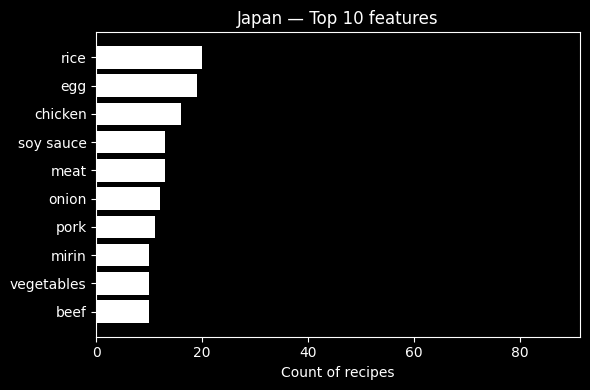

In [266]:
import pandas as pd
import matplotlib.pyplot as plt

# Universal colors
BACKGROUND_COLOR = "black"
LABEL_COLOR = "white"


def plot_cluster_feature_usage(
    matrix,
    clusters,
    cluster_id,
    cluster_labels=None,
    threshold=0.0,
    top_n=10,
    figsize=(6, 4),
):
    """
    Plot top features used across items in a cluster by thresholding,
    binarizing, and counting presence.

    A feature is counted if value > threshold.
    """

    # ------------------------------------------------------------
    # Resolve cluster label (optional)
    # ------------------------------------------------------------
    cluster_label = None
    if cluster_labels is not None and hasattr(cluster_labels, "loc"):
        row = cluster_labels.loc[cluster_labels["cluster"] == cluster_id]
        if not row.empty and "label" in row.columns:
            cluster_label = row.iloc[0]["label"]

    if cluster_label is None:
        cluster_label = f"Cluster {cluster_id}"

    # ------------------------------------------------------------
    # Subset matrix to cluster items
    # ------------------------------------------------------------
    items = list(clusters.cluster_to_labels.get(cluster_id, []))
    if not items:
        raise ValueError(f"Cluster {cluster_id} is empty")

    df = matrix.df.loc[items]
    n_items = len(items)

    # ------------------------------------------------------------
    # THRESHOLD → BINARIZE → COUNT
    # ------------------------------------------------------------
    binary = (df > threshold).astype(int)
    counts = binary.sum(axis=0)
    counts = counts[counts > 0].sort_values(ascending=False)

    if counts.empty:
        raise ValueError(f"No features exceed threshold in cluster {cluster_id}")

    top = counts.head(top_n)[::-1]

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    plt.figure(figsize=figsize)
    fig = plt.gcf()
    ax = plt.gca()
    fig.patch.set_facecolor(BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)

    plt.barh(top.index, top.values, color=LABEL_COLOR)

    plt.xlabel(
        "Count of recipes",
        color=LABEL_COLOR,
    )
    plt.title(
        f"{cluster_label} — Top {len(top)} features",
        color=LABEL_COLOR,
    )
    ax.tick_params(colors=LABEL_COLOR)

    for spine in ax.spines.values():
        spine.set_color(LABEL_COLOR)

    plt.xlim(0, max(n_items, top.values.max()) * 1.05)

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# Cluster ID → label mapping (from enrichment)
# ------------------------------------------------------------
plot_cluster_feature_usage(
    matrix=results.matrix,
    clusters=results.clusters,
    cluster_id=6,  # example: kenya india
    cluster_labels=cluster_labels,
    top_n=10,
    threshold=0.5,
)

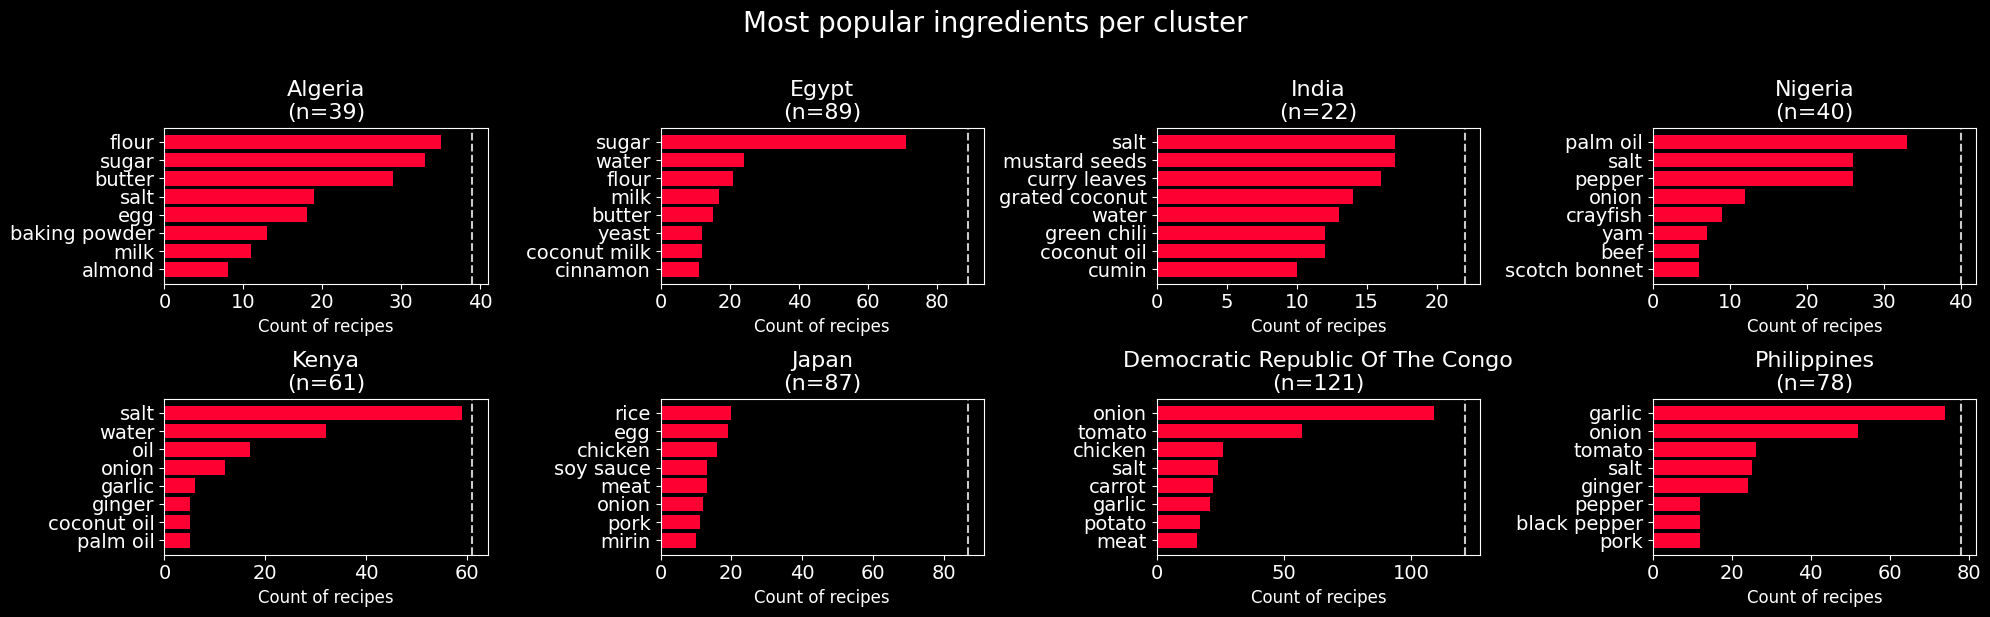

In [268]:
import math
import matplotlib.pyplot as plt

# Shared styling (reused from notebook namespace if present)
LABEL_COLOR = globals().get("LABEL_COLOR", "black")
BACKGROUND_COLOR = globals().get("BACKGROUND_COLOR", "white")


def _truncate_label(label, max_chars):
    if max_chars is None:
        return label
    if len(label) <= max_chars:
        return label
    return label[: max_chars - 3] + "..."


def plot_cluster_feature_usage_grid(
    matrix,
    clusters,
    cluster_labels,
    cluster_ids=None,
    threshold=0.0,
    top_n=10,
    ncols=None,
    figsize_per_ax=(4, 3),
    max_label_chars=25,
):
    """
    Plot feature-usage barplots for multiple clusters in a grid.

    Parameters
    ----------
    matrix : Matrix
        Item × feature binary matrix.
    clusters : Clusters
        Clusters object with cluster_to_labels mapping.
    cluster_labels : DataFrame
        Output of summarize_clusters(), with columns ['cluster', 'label'].
    cluster_ids : list[int] or None
        Cluster IDs to plot. If None, uses all clusters in cluster_labels.
    top_n : int
        Top features per cluster.
    ncols : int or None
        Number of columns. If None, choose square-ish layout.
    figsize_per_ax : tuple
        Size per subplot (width, height).
    """

    # -----------------------------
    # Resolve cluster IDs
    # -----------------------------
    if cluster_ids is None:
        cluster_ids = list(cluster_labels["cluster"])

    n = len(cluster_ids)

    # -----------------------------
    # Grid geometry
    # -----------------------------
    if ncols is None:
        ncols = math.ceil(math.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(figsize_per_ax[0] * ncols, figsize_per_ax[1] * nrows),
        squeeze=False,
    )
    fig.patch.set_facecolor(BACKGROUND_COLOR)
    # Reduce excessive whitespace between subplots
    fig.subplots_adjust(
        left=0.06,
        right=0.98,
        top=0.90,
        bottom=0.08,
        wspace=0.35,
        hspace=0.45,
    )

    label_map = dict(zip(cluster_labels.cluster, cluster_labels.label))

    # -----------------------------
    # Plot each cluster
    # -----------------------------
    for ax, cid in zip(axes.flat, cluster_ids):
        ax.set_facecolor(BACKGROUND_COLOR)
        recipes = list(clusters.cluster_to_labels[cid])
        df = matrix.df.loc[recipes]
        n_items = len(recipes)

        binary = (df > threshold).astype(int)
        counts = binary.sum(axis=0)
        counts = counts[counts > 0].sort_values(ascending=False)

        if counts.empty:
            ax.axis("off")
            continue

        top = counts.head(top_n)[::-1]

        labels = [_truncate_label(lbl, max_label_chars) for lbl in top.index]
        ax.barh(labels, top.values, color="#FF0033")

        ax.axvline(
            n_items,
            color=LABEL_COLOR,
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
        )

        label = label_map.get(cid, f"Cluster {cid}")
        ax.set_title(f"{label}\n(n={n_items})", fontsize=16, color=LABEL_COLOR)

        ax.set_xlim(0, max(n_items, top.values.max()) * 1.05)
        for spine in ax.spines.values():
            spine.set_color(LABEL_COLOR)
        ax.tick_params(axis="x", labelsize=14, colors=LABEL_COLOR)
        ax.tick_params(axis="y", labelsize=14, colors=LABEL_COLOR)
        ax.set_xlabel(
            f"Count of recipes",
            fontsize=12,
            color=LABEL_COLOR,
        )

    # -----------------------------
    # Hide unused axes
    # -----------------------------
    for ax in axes.flat[n:]:
        ax.axis("off")

    fig.suptitle(
        f"Most popular ingredients per cluster",
        fontsize=20,
        y=1.02,
        color=LABEL_COLOR,
    )
    plt.tight_layout()
    plt.show()


plot_cluster_feature_usage_grid(
    matrix=results.matrix,
    clusters=results.clusters,
    cluster_labels=cluster_labels,
    top_n=8,
    threshold=0.5,
    max_label_chars=20,
    ncols=4,
    figsize_per_ax=(5, 3),
)